<a href="https://colab.research.google.com/github/masadeghi/EHRsample/blob/main/EHRsample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import the data from your Google drive account:**

After running the first cell, you'll need to authorize access to your Drive.

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip gdrive/MyDrive/Databases/proj2.zip

Archive:  gdrive/MyDrive/Databases/proj2.zip
  inflating: hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/LICENSE.txt  
  inflating: hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/SHA256SUMS.txt  
  inflating: hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/dat.csv  
  inflating: hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/dat_md.csv  
  inflating: hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/dataDictionary.csv  


In [3]:
import pandas as pd

heart_data = pd.read_csv('/content/hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/dat.csv', index_col = 0)
md_data = pd.read_csv('/content/hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/dat_md.csv', index_col = 0)
dict_data = pd.read_csv('/content/hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/dataDictionary.csv', index_col = 0)

In [4]:
# # Understand the columns in the dataset
# %load_ext google.colab.data_table
# dict_data

Transform the dat_md dataset to represent drug administration using one-hot encoding. Each row will indicate a unique patient (`inpatient.number`) and each column will indicating a unique drug. The transformed dataset can then be concatenated with the main dataset.

In [5]:
# print('md_data dimensions: ', md_data.shape)
# %reload_ext google.colab.data_table
# md_data

In [6]:
# One-hot encoding drug administrations
import numpy as np

# Initialize zeros matrix with desired dimensions, indexes, and column names
drugs = np.zeros((len(heart_data['inpatient.number'].unique()),
                  len(md_data['Drug_name'].unique())))

drugs = pd.DataFrame(drugs, index = heart_data['inpatient.number'].unique(), columns = md_data['Drug_name'].unique())

# Iterate over the rows and columns of the constructed matrix and repalce 0 with 1
# in the appropriate column if the treatment was administered.
for index, row in drugs.iterrows():
  for col in drugs.columns:
    subset = md_data.loc[md_data['inpatient.number'] == index, 'Drug_name']
    if col in subset.values:
      drugs.loc[index, col] = 1

# Concatenate the resulting matrix the main dataset:
# Total data (t_data) = main dataset + drug data
heart_data.set_index('inpatient.number', inplace = True)

t_data = pd.concat([heart_data, drugs], axis = 1)

Identify features with missing data and explore each variable to get a better feel for the data.

In [7]:
# Percentage of missing data in each column (if present)
for i, col in enumerate(t_data.columns):
  if t_data[col].isnull().mean() > 0:
    print(f'{i, col}:', "%.2f" % t_data[col].isnull().mean())

(3, 'occupation'): 0.01
(26, 'peptic.ulcer.disease'): 0.00
(28, 'moderate.to.severe.chronic.kidney.disease'): 0.00
(33, 'liver.disease'): 0.00
(35, 'CCI.score'): 0.00
(45, 'LVEF'): 0.68
(46, 'left.ventricular.end.diastolic.diameter.LV'): 0.35
(47, 'mitral.valve.EMS'): 0.51
(48, 'mitral.valve.AMS'): 0.73
(49, 'EA'): 0.80
(50, 'tricuspid.valve.return.velocity'): 0.61
(51, 'tricuspid.valve.return.pressure'): 0.91
(59, 'time.of.death..days.from.admission.'): 0.98
(60, 're.admission.time..days.from.admission.'): 0.55
(61, 'return.to.emergency.department.within.6.months'): 0.00
(62, 'time.to.emergency.department.within.6.months'): 0.55
(63, 'creatinine.enzymatic.method'): 0.01
(64, 'urea'): 0.01
(65, 'uric.acid'): 0.01
(66, 'glomerular.filtration.rate'): 0.03
(67, 'cystatin'): 0.02
(68, 'white.blood.cell'): 0.01
(69, 'monocyte.ratio'): 0.01
(70, 'monocyte.count'): 0.01
(71, 'red.blood.cell'): 0.01
(72, 'coefficient.of.variation.of.red.blood.cell.distribution.width'): 0.01
(73, 'standard.devi

In [8]:
# You could use the following function for quick exploration of each variable
def summary(colname):
  col = t_data[colname]

  print(col[:10])

  if col.dtype == object:
    print('\n Unique factors: \n', col.unique())
    print('\n', col.describe(include = 'object'))
  else:
    print('\n', col.describe())

summary("dischargeDay")

857781    11
743087     8
866418     5
775928    11
810128     5
823318     6
844094    10
787530    27
795420    20
829801     4
Name: dischargeDay, dtype: int64

 count    2008.000000
mean        9.420817
std         8.030256
min         1.000000
25%         6.000000
50%         8.000000
75%        10.000000
max       123.000000
Name: dischargeDay, dtype: float64


# **Prepare data for building the models**

##**Step 1: Classify variables**
Explore the variables in the main dataset to classify them into the following categories:

*   Variables that are expected to be available at the time of admission or a short while after (e.g., preliminary lab data)
*   Variables that are expected to be available only at the time of discharge
*   Variables from echocardiography
*   Variables that are expected to be available only after patient discharge and on patient follow-up




In [9]:
# Note that the indices used here are 1 unit smaller than the original dataset,
# because we converted the first column ('inpatient.number') into indices and
# dropped it from the dataset. So for example, DestinationDischarge was the 
# second column in the original dataset (i.e., index = 1), but now it is the
# first (i.e., index = 0).

# Variables availble at the time of discharge, including duration of hospital stay
discharge_var = [0, 4, 52, 163]

# Variables only available after discharge and on patient follow-up
future_var = list(range(53,63))

# Variables from an echocardiography
echo_var = list(range(45,52))

##**Step 2: Split data into predictor and target datasets**

*   Separate data into predictor (X) and target (y) data.
*   Remove discharge and future variables from X
*   Remove variables with more than 30% missing values from X (echo variables are removed as a result).
*   log transform y because it is right skewed

In [10]:
# Remove discharge and future variables
y = t_data['dischargeDay']
X = t_data.drop(t_data.columns[discharge_var + future_var], axis = 1) # dischargeDay is within discharge_var

In [11]:
# Remove variables with more than 30% missing data
keepers = [True] * len(X.columns)

for i, col in enumerate(X.columns):
  if X[col].isnull().mean() > 0.3: # This also removes all echo_vars
    keepers[i] = False

X = X.loc[:, keepers]

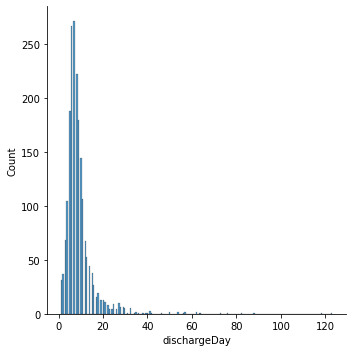

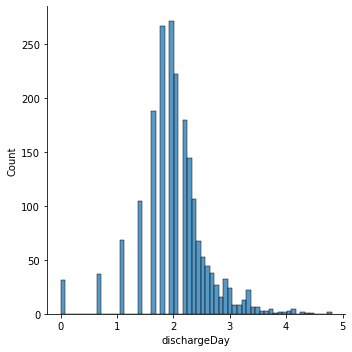

In [12]:
# log transform y
import seaborn as sns
sns.displot(y)
y = np.log(y)
sns.displot(y)

##**Step 3: Onehot encode categorical variables**
One-hot encode the categorical variables in the dataset.

In [13]:
import numpy as np

# Replace NAs with mode in the categorical (dtype = 'object') variables.
# occupation is the only categorical variable with missing values
value = X['occupation'].mode()[0]
X['occupation'].replace(np.nan, value, inplace = True)

# OneHotencoding
from sklearn.preprocessing import OneHotEncoder

X_obj = X.select_dtypes(include = ['object']).copy()
enc = OneHotEncoder(sparse = False) #sparse = False to enable concatenation with the noncategorical variables.
X_obj_enc = enc.fit_transform(X_obj)
X_obj_enc = pd.DataFrame(X_obj_enc, columns = enc.get_feature_names_out(), index = X.index)

#Replace object variables with the onehot encoded version in the original dataset
X.drop(X_obj.columns,
       axis = 1,
       inplace = True)

X = pd.concat([X_obj_enc, X], axis = 1)

## **Step 4: Split into train/test datasets and impute missing data**
*   Split the data into train and test groups
*   Impute missing values using a KNN imputer

Imputations for the test data is performed based on the train group fit to prevent leakage.

In [14]:
# Split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Save indices for future data modificatons
train_indices = X_train.index
test_indices = X_test.index

In [15]:
# Impute missing values using the KNN imputer
from sklearn.impute import KNNImputer

imp = KNNImputer()

X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)

##**Step 5: Normalization**
Scale data and compare three scaling methods:

###1. MinMax normalization

In [16]:
# Scale using MinMax
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_minmax = scaler.fit_transform(X_train)
X_test_minmax = scaler.transform(X_test)

###2. Standard scaling all columns in the dataset

In [17]:
# # Standard scale all variables
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

# X_train_all_std = scaler.fit_transform(X_train)
# X_test_all_std = scaler.transform(X_test)

###3. Standard scaling only the non-onehot-encoded columns in the dataset

In [18]:
# # Standard scale only the non-onehot-encoded variables
# from sklearn.preprocessing import StandardScaler

# # Removing one-hot encoded variables from scaling
# X_train = pd.DataFrame(X_train, index = train_indices, columns = X.columns)
# X_test = pd.DataFrame(X_test, index = test_indices, columns = X.columns)

# non_onehot = [col for col in X_train.columns if len(X_train[col].unique()) != 2]

# X_train_non_onehot = X_train.loc[:, non_onehot]
# X_train_onehot = X_train.drop(non_onehot, axis = 1)

# X_test_non_onehot = X_test.loc[:, non_onehot]
# X_test_onehot = X_test.drop(non_onehot, axis = 1)

# # Standard scale the non-encoded variables
# # Concatenate the resulting dataframe with the rest of the data.
# scaler = StandardScaler()

# X_train_non_onehot_scaled = scaler.fit_transform(X_train_non_onehot)
# X_train_non_onehot_scaled = pd.DataFrame(X_train_non_onehot_scaled, index = X_train_non_onehot.index, columns = X_train_non_onehot.columns)
# X_train_part_std = pd.concat([X_train_non_onehot_scaled, X_train_onehot], axis = 1)

# X_test_non_onehot_scaled = scaler.transform(X_test_non_onehot)
# X_test_non_onehot_scaled = pd.DataFrame(X_test_non_onehot_scaled, index = X_test_non_onehot.index, columns = X_test_non_onehot.columns)
# X_test_part_std = pd.concat([X_test_non_onehot_scaled, X_test_onehot], axis = 1)

# **Build regularized linear regression model for prediction of hospitalization duration**

In [19]:
# Suppress convergence warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Regularized linear model
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error

# Type 1 scaling
print("The results using data scaled with method 1:")

lin_reg = ElasticNetCV(l1_ratio = [0, 0.2, 0.5, 0.8, 0.9, 0.95, 0.99, 1],
                       alphas = [0, 0.1, 0.2, 0.5, 0.7, 0.9, 1])

lin_reg.fit(X_train_minmax, y_train)
y_pred = lin_reg.predict(X_test_minmax)

print('\nMSE for lin_reg is: ', mean_squared_error(y_test, y_pred))
print('\nChosen l1-ratio: ', lin_reg.l1_ratio_)
print('\nChosen alpha: ', lin_reg.alpha_)

# # Type 2 scaling
# print("\n__________________________________\n")
# print("The results using data scaled with method 2:")

# lin_reg = ElasticNetCV(l1_ratio = [0, 0.2, 0.5, 0.8, 0.9, 0.95, 0.99, 1],
#                        alphas = [0, 0.1, 0.2, 0.5, 0.7, 0.9, 1])

# lin_reg.fit(X_train_all_std, y_train)
# y_pred = lin_reg.predict(X_test_all_std)

# print('\nMSE for lin_reg is: ', mean_squared_error(y_test, y_pred))
# print('\nChosen l1-ratio: ', lin_reg.l1_ratio_)
# print('\nChosen alpha: ', lin_reg.alpha_)

# # Type 3 scaling
# print("\n__________________________________\n")
# print("The results using data scaled with method 3:")

# lin_reg = ElasticNetCV(l1_ratio = [0, 0.2, 0.5, 0.8, 0.9, 0.95, 0.99, 1],
#                        alphas = [0, 0.1, 0.2, 0.5, 0.7, 0.9, 1])

# lin_reg.fit(X_train_part_std, y_train)
# y_pred = lin_reg.predict(X_test_part_std)

# print('\nMSE for lin_reg is: ', mean_squared_error(y_test, y_pred))
# print('\nChosen l1-ratio: ', lin_reg.l1_ratio_)
# print('\nChosen alpha: ', lin_reg.alpha_)

The results using data scaled with method 1:

MSE for lin_reg is:  0.2665744616538104

Chosen l1-ratio:  0.0

Chosen alpha:  0.1


# **Build support vector regressor for prediction of hospitalization duration**

In [ ]:
# # If you don't want to run the grid search, you could use the following parameters:
# # C = 0.1, gamma = 1, kernel = linear (next cell)


# from sklearn.svm import SVR
# from sklearn.model_selection import GridSearchCV

# sv_reg = SVR()

# param_grid = {'kernel' : ['linear', 'rbf', 'poly'],
#               'gamma' : [0.2, 0.5, 1, 5],
#               'C' : [0.1, 1, 10, 30]}

# sv_reg = GridSearchCV(sv_reg, param_grid = param_grid, 
#                               verbose = 3, cv = 5, scoring = 'neg_mean_squared_error')

# sv_reg.fit(X_train, y_train)

# print('\nBest estimator: \n', sv_reg.best_estimator_)
# print('\nBest score: \n', sv_reg.best_score_)
# print('\nBest parameters: \n', sv_reg.best_params_)

# y_pred = sv_reg.best_estimator_.predict(X_test)

# print('\nMSE on test data: ', mean_squared_error(y_test, y_pred))

In [20]:
# SVR using the optimum parameters
from sklearn.svm import SVR

# Type 1 scaling
print("The results using data scaled with method 1:")

sv_reg = SVR(kernel = 'linear', gamma = 1, C = 0.1)

sv_reg.fit(X_train_minmax, y_train)
y_pred = sv_reg.predict(X_test_minmax)

print('\nMSE for sv_reg is: ', mean_squared_error(y_test, y_pred))

# # Type 2 scaling
# print("\n__________________________________\n")
# print("The results using data scaled with method 2:")

# sv_reg = SVR(kernel = 'linear', gamma = 1, C = 0.1)

# sv_reg.fit(X_train_all_std, y_train)
# y_pred = sv_reg.predict(X_test_all_std)

# print('\nMSE for sv_reg is: ', mean_squared_error(y_test, y_pred))

# # Type 3 scaling
# print("\n__________________________________\n")
# print("The results using data scaled with method 3:")

# sv_reg = SVR(kernel = 'linear', gamma = 1, C = 0.1)

# sv_reg.fit(X_train_part_std, y_train)
# y_pred = sv_reg.predict(X_test_part_std)

# print('\nMSE for sv_reg is: ', mean_squared_error(y_test, y_pred))

The results using data scaled with method 1:

MSE for sv_reg is:  0.2650978805431524


# **Build random forest model for prediction of hospitalization duration**

**Base model:**

In [21]:
from sklearn.ensemble import RandomForestRegressor

# Type 1 scaling
print("The results using data scaled with method 1:")

nl_reg = RandomForestRegressor(random_state = 42)

nl_reg.fit(X_train_minmax, y_train)
y_pred = nl_reg.predict(X_test_minmax)

print('\nMSE for end_reg is: ', mean_squared_error(y_test, y_pred))

# # Type 2 scaling
# print("\n__________________________________\n")
# print("The results using data scaled with method 2:")

# nl_reg = RandomForestRegressor(random_state = random.seed(1))

# nl_reg.fit(X_train_all_std, y_train)
# y_pred = nl_reg.predict(X_test_all_std)

# print('\nMSE for rnd_reg is: ', mean_squared_error(y_test, y_pred))

# # Type 3 scaling
# print("\n__________________________________\n")
# print("The results using data scaled with method 3:")

# nl_reg = RandomForestRegressor(random_state = random.seed(1))

# nl_reg.fit(X_train_part_std, y_train)
# y_pred = nl_reg.predict(X_test_part_std)

# print('\nMSE for rnd_reg is: ', mean_squared_error(y_test, y_pred))

The results using data scaled with method 1:

MSE for end_reg is:  0.26932714027439175


##Tune hyperparameters using grid search cross-validation:

The code cell is commented out as it did not improve model performance while being computationally time-consuming.

In [ ]:
# # Hyperparameter tuning using grid search

# from sklearn.model_selection import GridSearchCV

# grd_reg = RandomForestRegressor()

# param_grid = {'max_depth': [30, 40, 50],
#                'n_estimators': [150, 200, 250]}

# grd_reg = GridSearchCV(estimator = grd_reg, param_grid = param_grid, 
#                                cv = 5, verbose = 3, n_jobs = -1, scoring = 'neg_mean_squared_error')

# grd_reg.fit(X_train, y_train)

# print('\nBest estimator: \n', grd_reg.best_estimator_)
# print('\nBest score: \n', grd_reg.best_score_)
# print('\nBest parameters: \n', grd_reg.best_params_)

# y_pred = grd_reg.best_estimator_.predict(X_test)

# print('\nMSE on test data: ', mean_squared_error(y_test, y_pred))

##Tune hyperparameters using randomized search cross-validation:

The code cell is commented out as it did not improve model performance while being computationally time-consuming.

In [ ]:
# # Hyperparameter tuning using randomized search (the main differentiator from
# # the previous cell is the max_features hyperparameter)

# from sklearn.model_selection import RandomizedSearchCV

# rnd_reg = RandomForestRegressor()

# random_grid = {'max_depth': [2, 16, 32, 64, None],
#                'n_estimators': [64, 256, 512],
#                'max_features': ['sqrt', 0.2, 'auto']}

# rnd_reg = RandomizedSearchCV(estimator = rnd_reg, param_distributions = random_grid, 
#                                cv = 5, verbose = 3, n_jobs = -1, random_state = 42, scoring = 'neg_mean_squared_error')

# rnd_reg.fit(X_train, y_train)

# print('\nBest estimator \n', rnd_reg.best_estimator_)
# print('\nBest score \n', rnd_reg.best_score_)
# print('\nBest parameters \n', rnd_reg.best_params_)

# y_pred = rnd_re.best_estimator_.predict(X_test)

# print('\nMSE on test data:', mean_squared_error(y_test, y_pred))

##Extract feature importances:

In [ ]:
forest_importance = pd.Series(nl_reg.feature_importances_,
                              index = X_train.columns).sort_values(ascending = False)

forest_importance[:10]

Torasemide tablet                  0.037065
Furosemide tablet                  0.035587
carbon.dioxide.binding.capacity    0.025066
cystatin                           0.024320
creatine.kinase.isoenzyme          0.018745
chloride                           0.018652
uric.acid                          0.018447
urea                               0.018395
platelet                           0.017509
total.protein                      0.016943
dtype: float64

# **Build super ensemble (voting regressor) model**

In [22]:
from sklearn.ensemble import VotingRegressor

# Type 1 scaling
print("The results using data scaled with method 1:")

vote_reg = VotingRegressor(estimators = [('rf', nl_reg), ('lin', lin_reg), ('svr', sv_reg)])

vote_reg.fit(X_train_minmax, y_train)
y_pred = vote_reg.predict(X_test_minmax)

print('\nMSE for sv_reg is: ', mean_squared_error(y_test, y_pred))

# # Type 2 scaling
# print("\n__________________________________\n")
# print("The results using data scaled with method 2:")

# vote_reg = VotingRegressor(estimators = [('rf', nl_reg), ('lin', lin_reg), ('svr', sv_reg)])

# vote_reg.fit(X_train_all_std, y_train)
# y_pred = vote_reg.predict(X_test_all_std)

# print('\nMSE for sv_reg is: ', mean_squared_error(y_test, y_pred))

# # Type 3 scaling
# print("\n__________________________________\n")
# print("The results using data scaled with method 3:")

# vote_reg = VotingRegressor(estimators = [('rf', nl_reg), ('lin', lin_reg), ('svr', sv_reg)])

# vote_reg.fit(X_train_part_std, y_train)
# y_pred = vote_reg.predict(X_test_part_std)

# print('\nMSE for sv_reg is: ', mean_squared_error(y_test, y_pred))

The results using data scaled with method 1:

MSE for sv_reg is:  0.25572273237199433


# **Build a neural network regressor**

In [20]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed
tf.random.set_seed(42)

## Convert datasets to tensors

In [82]:
# Convert data into tensors
X_train_minmax_tensor = tf.cast(tf.constant(np.array(X_train_minmax)), dtype = tf.float32) # MinMax standardization gives the best results (experimentation not shown)
X_test_minmax_tensor = tf.cast(tf.constant(np.array(X_test_minmax)), dtype = tf.float32)

# X_train_all_std_tensor = tf.cast(tf.constant(np.array(X_train_all_std)), dtype = tf.float32)
# X_test_all_std_tensor = tf.cast(tf.constant(np.array(X_test_all_std)), dtype = tf.float32)

# X_train_part_std_tensor = tf.cast(tf.constant(np.array(X_train_part_std)), dtype = tf.float32)
# X_test_part_std_tensor = tf.cast(tf.constant(np.array(X_test_part_std)), dtype = tf.float32)

y_train_tensor = tf.cast(tf.constant(np.array(y_train)), dtype = tf.float32)
y_test_tensor = tf.cast(tf.constant(np.array(y_test)), dtype = tf.float32)

In [83]:
# Split test_data into validation and test data
X_val_minmax_tensor, X_test_minmax_tensor = tf.split(X_test_minmax_tensor, 2, axis = 0) # MinMax standardization gives the best results (experimentation not shown)

# X_val_all_std_tensor, X_test_all_std_tensor = tf.split(X_test_all_std_tensor, 2, axis = 0)

# X_val_part_std_tensor, X_test_part_std_tensor = tf.split(X_test_part_std_tensor, 2, axis = 0)

y_val_tensor, y_test_tensor = tf.split(y_test_tensor, 2, axis = 0)

## Create TensorBoard callback

In [23]:
# Create TensorBoard callback
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Create function for plotting loss and MSE curves

In [44]:
# Create a function to plot loss_curves
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.
  
  Returns:
    Plots of training/validation loss.
  """

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  mse = history.history["mse"]
  val_mse = history.history["val_mse"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label = "Training loss")
  plt.plot(epochs, val_loss, label = "Validation loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot mse
  plt.figure()
  plt.plot(epochs, mse, label = "Training MSE")
  plt.plot(epochs, val_mse, label = "Validation MSE")
  plt.title("MSE")
  plt.xlabel("Epochs")
  plt.legend()

## Build models and experiment to find final architecture

### Model_0 (Base model)

In [25]:
model_0 = tf.keras.Sequential([
    layers.Dense(166, input_shape = X_train_minmax_tensor[0].shape, name = "input_layer"),
    layers.Dense(100, activation = "relu"),
    layers.Dense(1, name = "output_layer")
])

model_0.compile(loss = tf.keras.losses.mse,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ["mse"])

model_0_history  = model_0.fit(x = X_train_minmax_tensor, 
                               y = y_train_tensor, 
                               epochs = 10,
                               validation_data = (X_val_minmax_tensor, y_val_tensor),
                               callbacks = [create_tensorboard_callback(dir_name = "nn-predictions",
                                                   experiment_name = "Model_0")])

Saving TensorBoard log files to: nn-predictions/Model_0/20221127-122801
Epoch 1/10
51/51 [==============================] - 2s 8ms/step - loss: 0.9546 - mse: 0.9546 - val_loss: 0.3307 - val_mse: 0.3307
Epoch 2/10
51/51 [==============================] - 0s 3ms/step - loss: 0.3780 - mse: 0.3780 - val_loss: 0.3073 - val_mse: 0.3073
Epoch 3/10
51/51 [==============================] - 0s 4ms/step - loss: 0.3448 - mse: 0.3448 - val_loss: 0.2872 - val_mse: 0.2872
Epoch 4/10
51/51 [==============================] - 0s 4ms/step - loss: 0.3236 - mse: 0.3236 - val_loss: 0.2806 - val_mse: 0.2806
Epoch 5/10
51/51 [==============================] - 0s 4ms/step - loss: 0.3070 - mse: 0.3070 - val_loss: 0.2716 - val_mse: 0.2716
Epoch 6/10
51/51 [==============================] - 0s 4ms/step - loss: 0.2963 - mse: 0.2963 - val_loss: 0.2661 - val_mse: 0.2661
Epoch 7/10
51/51 [==============================] - 0s 4ms/step - loss: 0.2877 - mse: 0.2877 - val_loss: 0.2609 - val_mse: 0.2609
Epoch 8/10
51/51 [

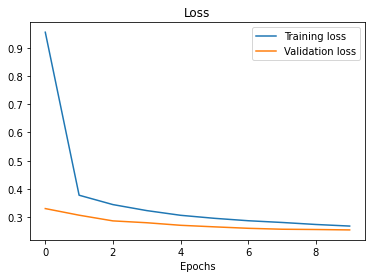

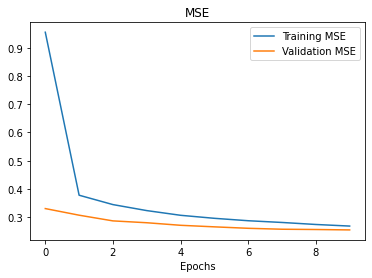

In [45]:
plot_loss_curves(model_0_history)

### Model_1 (Add 1 hidden layer to improve bias)

In [27]:
model_1 = tf.keras.Sequential([
    layers.Dense(166, input_shape = X_train_minmax_tensor[0].shape, name = "input_layer"),
    layers.Dense(100, activation = "relu"),
    layers.Dense(100, activation = "relu"),
    layers.Dense(1, name = "output_layer")
])

model_1.compile(loss = tf.keras.losses.mse,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ["mse"])

model_1_history  = model_1.fit(x = X_train_minmax_tensor, 
                               y = y_train_tensor, 
                               epochs = 10,
                               validation_data = (X_val_minmax_tensor, y_val_tensor),
                               callbacks = [create_tensorboard_callback(dir_name = "nn-predictions",
                                                   experiment_name = "Model_1")])

Saving TensorBoard log files to: nn-predictions/Model_1/20221127-122823
Epoch 1/10
51/51 [==============================] - 1s 7ms/step - loss: 1.3142 - mse: 1.3142 - val_loss: 0.3738 - val_mse: 0.3738
Epoch 2/10
51/51 [==============================] - 0s 4ms/step - loss: 0.3705 - mse: 0.3705 - val_loss: 0.3233 - val_mse: 0.3233
Epoch 3/10
51/51 [==============================] - 0s 4ms/step - loss: 0.3395 - mse: 0.3395 - val_loss: 0.3035 - val_mse: 0.3035
Epoch 4/10
51/51 [==============================] - 0s 4ms/step - loss: 0.3227 - mse: 0.3227 - val_loss: 0.3000 - val_mse: 0.3000
Epoch 5/10
51/51 [==============================] - 0s 5ms/step - loss: 0.3073 - mse: 0.3073 - val_loss: 0.2885 - val_mse: 0.2885
Epoch 6/10
51/51 [==============================] - 0s 4ms/step - loss: 0.2963 - mse: 0.2963 - val_loss: 0.2786 - val_mse: 0.2786
Epoch 7/10
51/51 [==============================] - 0s 5ms/step - loss: 0.2866 - mse: 0.2866 - val_loss: 0.2718 - val_mse: 0.2718
Epoch 8/10
51/51 [

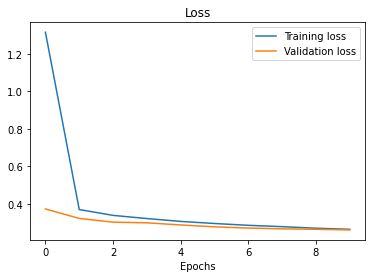

In [28]:
plot_loss_curves(model_1_history)

### Model_2 (Add 3 hidden layers to improve bias)

In [29]:
model_2 = tf.keras.Sequential([
    layers.Dense(166, input_shape = X_train_minmax_tensor[0].shape, name = "input_layer"),
    layers.Dense(100, activation = "relu"),
    layers.Dense(100, activation = "relu"),
    layers.Dense(100, activation = "relu"),
    layers.Dense(100, activation = "relu"),
    layers.Dense(1, name = "output_layer")
])

model_2.compile(loss = tf.keras.losses.mse,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ["mse"])

model_2_history  = model_2.fit(x = X_train_minmax_tensor, 
                               y = y_train_tensor, 
                               epochs = 10,
                               validation_data = (X_val_minmax_tensor, y_val_tensor),
                               callbacks = [create_tensorboard_callback(dir_name = "nn-predictions",
                                                   experiment_name = "Model_2")])

Saving TensorBoard log files to: nn-predictions/Model_2/20221127-122845
Epoch 1/10
51/51 [==============================] - 2s 18ms/step - loss: 1.6446 - mse: 1.6446 - val_loss: 0.3557 - val_mse: 0.3557
Epoch 2/10
51/51 [==============================] - 1s 11ms/step - loss: 0.3544 - mse: 0.3544 - val_loss: 0.2915 - val_mse: 0.2915
Epoch 3/10
51/51 [==============================] - 0s 6ms/step - loss: 0.3293 - mse: 0.3293 - val_loss: 0.2813 - val_mse: 0.2813
Epoch 4/10
51/51 [==============================] - 0s 8ms/step - loss: 0.3189 - mse: 0.3189 - val_loss: 0.2847 - val_mse: 0.2847
Epoch 5/10
51/51 [==============================] - 1s 11ms/step - loss: 0.3060 - mse: 0.3060 - val_loss: 0.2686 - val_mse: 0.2686
Epoch 6/10
51/51 [==============================] - 1s 11ms/step - loss: 0.2965 - mse: 0.2965 - val_loss: 0.2592 - val_mse: 0.2592
Epoch 7/10
51/51 [==============================] - 1s 11ms/step - loss: 0.2880 - mse: 0.2880 - val_loss: 0.2543 - val_mse: 0.2543
Epoch 8/10
51

### Model_3 (Add 10 training epochs to Model_1 to improve bias)

In [30]:
model_3 = tf.keras.Sequential([
    layers.Dense(166, input_shape = X_train_minmax_tensor[0].shape, name = "input_layer"),
    layers.Dense(100, activation = "relu"),
    layers.Dense(100, activation = "relu"),
    layers.Dense(1, name = "output_layer")
])

model_3.compile(loss = tf.keras.losses.mse,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ["mse"])

model_3_history  = model_3.fit(x = X_train_minmax_tensor, 
                               y = y_train_tensor, 
                               epochs = 20,
                               validation_data = (X_val_minmax_tensor, y_val_tensor),
                               callbacks = [create_tensorboard_callback(dir_name = "nn-predictions",
                                                   experiment_name = "Model_3")])

Saving TensorBoard log files to: nn-predictions/Model_3/20221127-122926
Epoch 1/20
51/51 [==============================] - 1s 10ms/step - loss: 1.8242 - mse: 1.8242 - val_loss: 0.3445 - val_mse: 0.3445
Epoch 2/20
51/51 [==============================] - 0s 5ms/step - loss: 0.3829 - mse: 0.3829 - val_loss: 0.3016 - val_mse: 0.3016
Epoch 3/20
51/51 [==============================] - 0s 4ms/step - loss: 0.3558 - mse: 0.3558 - val_loss: 0.2861 - val_mse: 0.2861
Epoch 4/20
51/51 [==============================] - 0s 5ms/step - loss: 0.3404 - mse: 0.3404 - val_loss: 0.2831 - val_mse: 0.2831
Epoch 5/20
51/51 [==============================] - 0s 5ms/step - loss: 0.3256 - mse: 0.3256 - val_loss: 0.2699 - val_mse: 0.2699
Epoch 6/20
51/51 [==============================] - 0s 5ms/step - loss: 0.3141 - mse: 0.3141 - val_loss: 0.2629 - val_mse: 0.2629
Epoch 7/20
51/51 [==============================] - 0s 4ms/step - loss: 0.3040 - mse: 0.3040 - val_loss: 0.2574 - val_mse: 0.2574
Epoch 8/20
51/51 

### Model_4 (Add 30 training epochs to improve bias)

In [31]:
model_4 = tf.keras.Sequential([
    layers.Dense(166, input_shape = X_train_minmax_tensor[0].shape, name = "input_layer"),
    layers.Dense(100, activation = "relu"),
    layers.Dense(100, activation = "relu"),
    layers.Dense(1, name = "output_layer")
])

model_4.compile(loss = tf.keras.losses.mse,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ["mse"])

model_4_history  = model_4.fit(x = X_train_minmax_tensor, 
                               y = y_train_tensor, 
                               epochs = 40,
                               validation_data = (X_val_minmax_tensor, y_val_tensor),
                               callbacks = [create_tensorboard_callback(dir_name = "nn-predictions",
                                                   experiment_name = "Model_4")])

Saving TensorBoard log files to: nn-predictions/Model_4/20221127-122948
Epoch 1/40
51/51 [==============================] - 3s 22ms/step - loss: 1.3115 - mse: 1.3115 - val_loss: 0.3643 - val_mse: 0.3643
Epoch 2/40
51/51 [==============================] - 1s 13ms/step - loss: 0.3998 - mse: 0.3998 - val_loss: 0.3113 - val_mse: 0.3113
Epoch 3/40
51/51 [==============================] - 1s 10ms/step - loss: 0.3555 - mse: 0.3555 - val_loss: 0.2820 - val_mse: 0.2820
Epoch 4/40
51/51 [==============================] - 1s 13ms/step - loss: 0.3304 - mse: 0.3304 - val_loss: 0.2757 - val_mse: 0.2757
Epoch 5/40
51/51 [==============================] - 1s 14ms/step - loss: 0.3095 - mse: 0.3095 - val_loss: 0.2604 - val_mse: 0.2604
Epoch 6/40
51/51 [==============================] - 1s 12ms/step - loss: 0.2944 - mse: 0.2944 - val_loss: 0.2532 - val_mse: 0.2532
Epoch 7/40
51/51 [==============================] - 1s 12ms/step - loss: 0.2831 - mse: 0.2831 - val_loss: 0.2469 - val_mse: 0.2469
Epoch 8/40


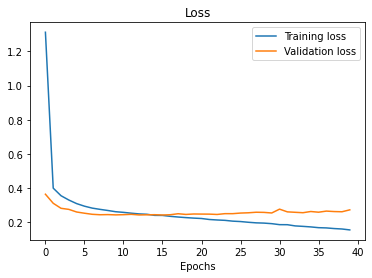

In [32]:
plot_loss_curves(model_4_history)

### Model_5 (Add l2 regularization to the hidden layers in Model_4 to improve variance)

In [34]:
from tensorflow.keras import regularizers

model_5 = tf.keras.Sequential([
    layers.Dense(166, input_shape = X_train_minmax_tensor[0].shape, name = "input_layer"),
    layers.Dense(100, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(100, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(1, name = "output_layer")
])

model_5.compile(loss = tf.keras.losses.mse,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ["mse"])

model_5_history  = model_5.fit(x = X_train_minmax_tensor, 
                               y = y_train_tensor, 
                               epochs = 40,
                               validation_data = (X_val_minmax_tensor, y_val_tensor),
                               callbacks = [create_tensorboard_callback(dir_name = "nn-predictions",
                                                   experiment_name = "Model_5")])

Saving TensorBoard log files to: nn-predictions/Model_5/20221127-125251
Epoch 1/40
51/51 [==============================] - 1s 8ms/step - loss: 3.4526 - mse: 1.2365 - val_loss: 2.5215 - val_mse: 0.3393
Epoch 2/40
51/51 [==============================] - 0s 4ms/step - loss: 2.4907 - mse: 0.3460 - val_loss: 2.4103 - val_mse: 0.3059
Epoch 3/40
51/51 [==============================] - 0s 5ms/step - loss: 2.3931 - mse: 0.3266 - val_loss: 2.3169 - val_mse: 0.2909
Epoch 4/40
51/51 [==============================] - 0s 4ms/step - loss: 2.3043 - mse: 0.3161 - val_loss: 2.2366 - val_mse: 0.2887
Epoch 5/40
51/51 [==============================] - 0s 5ms/step - loss: 2.2154 - mse: 0.3043 - val_loss: 2.1526 - val_mse: 0.2808
Epoch 6/40
51/51 [==============================] - 0s 5ms/step - loss: 2.1323 - mse: 0.2963 - val_loss: 2.0727 - val_mse: 0.2746
Epoch 7/40
51/51 [==============================] - 0s 5ms/step - loss: 2.0528 - mse: 0.2893 - val_loss: 1.9967 - val_mse: 0.2696
Epoch 8/40
51/51 [

### Model_6 (Increase learning_rate in model_5 to 0.01)


In [35]:
model_6 = tf.keras.Sequential([
    layers.Dense(166, input_shape = X_train_minmax_tensor[0].shape, name = "input_layer"),
    layers.Dense(100, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(100, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(1, name = "output_layer")
])

model_6.compile(loss = tf.keras.losses.mse,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
              metrics = ["mse"])

model_6_history  = model_6.fit(x = X_train_minmax_tensor, 
                               y = y_train_tensor, 
                               epochs = 40,
                               validation_data = (X_val_minmax_tensor, y_val_tensor),
                               callbacks = [create_tensorboard_callback(dir_name = "nn-predictions",
                                                   experiment_name = "Model_6")])

Saving TensorBoard log files to: nn-predictions/Model_6/20221127-125429
Epoch 1/40
51/51 [==============================] - 1s 9ms/step - loss: 2.2374 - mse: 0.7960 - val_loss: 1.2259 - val_mse: 0.3007
Epoch 2/40
51/51 [==============================] - 0s 4ms/step - loss: 1.0060 - mse: 0.3474 - val_loss: 0.8055 - val_mse: 0.3525
Epoch 3/40
51/51 [==============================] - 0s 5ms/step - loss: 0.6533 - mse: 0.3102 - val_loss: 0.5200 - val_mse: 0.2676
Epoch 4/40
51/51 [==============================] - 0s 5ms/step - loss: 0.5214 - mse: 0.3187 - val_loss: 0.4379 - val_mse: 0.2740
Epoch 5/40
51/51 [==============================] - 0s 4ms/step - loss: 0.4246 - mse: 0.2942 - val_loss: 0.3785 - val_mse: 0.2770
Epoch 6/40
51/51 [==============================] - 0s 5ms/step - loss: 0.3806 - mse: 0.2955 - val_loss: 0.3208 - val_mse: 0.2497
Epoch 7/40
51/51 [==============================] - 0s 5ms/step - loss: 0.3487 - mse: 0.2892 - val_loss: 0.3373 - val_mse: 0.2880
Epoch 8/40
51/51 [

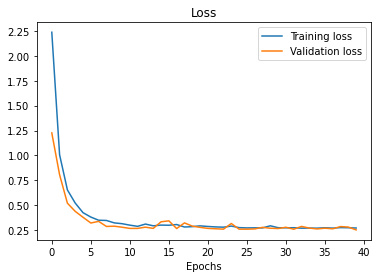

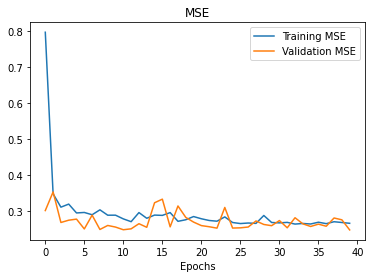

In [48]:
plot_loss_curves(model_6_history)

### Model_7 (Increase learning_rate in model_5 to 0.001)


In [37]:
model_7 = tf.keras.Sequential([
    layers.Dense(166, input_shape = X_train_minmax_tensor[0].shape, name = "input_layer"),
    layers.Dense(100, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(100, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(1, name = "output_layer")
])

model_7.compile(loss = tf.keras.losses.mse,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              metrics = ["mse"])

model_7_history  = model_7.fit(x = X_train_minmax_tensor, 
                               y = y_train_tensor, 
                               epochs = 40,
                               validation_data = (X_val_minmax_tensor, y_val_tensor),
                               callbacks = [create_tensorboard_callback(dir_name = "nn-predictions",
                                                   experiment_name = "Model_7")])

Saving TensorBoard log files to: nn-predictions/Model_7/20221127-125628
Epoch 1/40
51/51 [==============================] - 1s 8ms/step - loss: 2.3959 - mse: 0.4989 - val_loss: 1.8025 - val_mse: 0.2581
Epoch 2/40
51/51 [==============================] - 0s 4ms/step - loss: 1.5907 - mse: 0.2934 - val_loss: 1.3259 - val_mse: 0.2531
Epoch 3/40
51/51 [==============================] - 0s 5ms/step - loss: 1.2004 - mse: 0.2771 - val_loss: 1.0357 - val_mse: 0.2485
Epoch 4/40
51/51 [==============================] - 0s 5ms/step - loss: 0.9667 - mse: 0.2726 - val_loss: 0.8681 - val_mse: 0.2600
Epoch 5/40
51/51 [==============================] - 0s 4ms/step - loss: 0.8088 - mse: 0.2631 - val_loss: 0.7361 - val_mse: 0.2497
Epoch 6/40
51/51 [==============================] - 0s 4ms/step - loss: 0.7103 - mse: 0.2682 - val_loss: 0.6432 - val_mse: 0.2438
Epoch 7/40
51/51 [==============================] - 0s 4ms/step - loss: 0.6364 - mse: 0.2698 - val_loss: 0.7113 - val_mse: 0.3780
Epoch 8/40
51/51 [

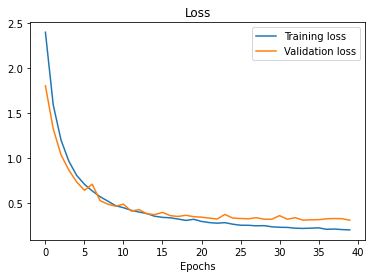

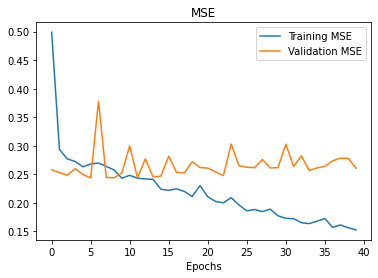

In [47]:
plot_loss_curves(model_7_history)

### Model_8 (train Model_5 for 40 more epochs)

In [39]:
model_8 = tf.keras.Sequential([
    layers.Dense(166, input_shape = X_train_minmax_tensor[0].shape, name = "input_layer"),
    layers.Dense(100, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(100, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(1, name = "output_layer")
])

model_8.compile(loss = tf.keras.losses.mse,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ["mse"])

model_8_history  = model_8.fit(x = X_train_minmax_tensor, 
                               y = y_train_tensor, 
                               epochs = 80,
                               validation_data = (X_val_minmax_tensor, y_val_tensor),
                               callbacks = [create_tensorboard_callback(dir_name = "nn-predictions",
                                                   experiment_name = "Model_8")])

Saving TensorBoard log files to: nn-predictions/Model_8/20221127-125858
Epoch 1/80
51/51 [==============================] - 1s 8ms/step - loss: 3.2484 - mse: 1.0120 - val_loss: 2.5421 - val_mse: 0.3366
Epoch 2/80
51/51 [==============================] - 0s 5ms/step - loss: 2.5499 - mse: 0.3768 - val_loss: 2.4484 - val_mse: 0.3106
Epoch 3/80
51/51 [==============================] - 0s 4ms/step - loss: 2.4476 - mse: 0.3431 - val_loss: 2.3512 - val_mse: 0.2825
Epoch 4/80
51/51 [==============================] - 0s 7ms/step - loss: 2.3595 - mse: 0.3243 - val_loss: 2.2843 - val_mse: 0.2850
Epoch 5/80
51/51 [==============================] - 0s 9ms/step - loss: 2.2739 - mse: 0.3074 - val_loss: 2.2037 - val_mse: 0.2724
Epoch 6/80
51/51 [==============================] - 0s 9ms/step - loss: 2.1963 - mse: 0.2971 - val_loss: 2.1271 - val_mse: 0.2621
Epoch 7/80
51/51 [==============================] - 0s 8ms/step - loss: 2.1220 - mse: 0.2882 - val_loss: 2.0584 - val_mse: 0.2577
Epoch 8/80
51/51 [

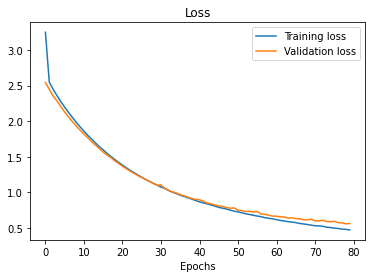

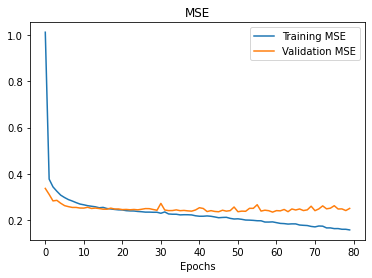

In [46]:
plot_loss_curves(model_8_history)

### Model_9 (adding dropout to Model_5 (prob = 0.5) to improve variance)

In [49]:
model_9 = tf.keras.Sequential([
    layers.Dense(166, input_shape = X_train_minmax_tensor[0].shape, name = "input_layer"),
    layers.Dense(100, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dropout(0.5),
    layers.Dense(100, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(1, name = "output_layer")
])

model_9.compile(loss = tf.keras.losses.mse,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ["mse"])

model_9_history  = model_9.fit(x = X_train_minmax_tensor, 
                               y = y_train_tensor, 
                               epochs = 40,
                               validation_data = (X_val_minmax_tensor, y_val_tensor),
                               callbacks = [create_tensorboard_callback(dir_name = "nn-predictions",
                                                   experiment_name = "Model_9")])

Saving TensorBoard log files to: nn-predictions/Model_9/20221127-131456
Epoch 1/40
51/51 [==============================] - 1s 8ms/step - loss: 3.5823 - mse: 1.3390 - val_loss: 2.5603 - val_mse: 0.3479
Epoch 2/40
51/51 [==============================] - 0s 5ms/step - loss: 2.8140 - mse: 0.6334 - val_loss: 2.5121 - val_mse: 0.3659
Epoch 3/40
51/51 [==============================] - 0s 5ms/step - loss: 2.6380 - mse: 0.5241 - val_loss: 2.4086 - val_mse: 0.3292
Epoch 4/40
51/51 [==============================] - 0s 6ms/step - loss: 2.5590 - mse: 0.5117 - val_loss: 2.3774 - val_mse: 0.3644
Epoch 5/40
51/51 [==============================] - 0s 10ms/step - loss: 2.4698 - mse: 0.4881 - val_loss: 2.2966 - val_mse: 0.3485
Epoch 6/40
51/51 [==============================] - 0s 9ms/step - loss: 2.3737 - mse: 0.4562 - val_loss: 2.2201 - val_mse: 0.3353
Epoch 7/40
51/51 [==============================] - 0s 8ms/step - loss: 2.2981 - mse: 0.4432 - val_loss: 2.1739 - val_mse: 0.3507
Epoch 8/40
51/51 

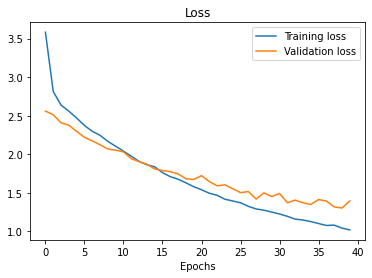

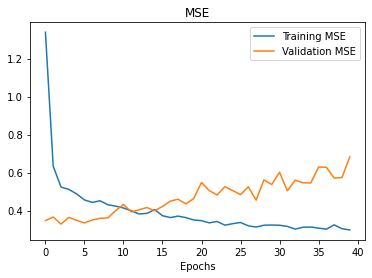

In [50]:
plot_loss_curves(model_9_history)

### Model_10 (Adding Dropout (prob = 0.2) to Model_5 to improve variance)

In [51]:
model_10 = tf.keras.Sequential([
    layers.Dense(166, input_shape = X_train_minmax_tensor[0].shape, name = "input_layer"),
    layers.Dense(100, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dropout(0.2),
    layers.Dense(100, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(1, name = "output_layer")
])

model_10.compile(loss = tf.keras.losses.mse,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ["mse"])

model_10_history  = model_10.fit(x = X_train_minmax_tensor, 
                               y = y_train_tensor, 
                               epochs = 40,
                               validation_data = (X_val_minmax_tensor, y_val_tensor),
                               callbacks = [create_tensorboard_callback(dir_name = "nn-predictions",
                                                   experiment_name = "Model_10")])

Saving TensorBoard log files to: nn-predictions/Model_10/20221127-131704
Epoch 1/40
51/51 [==============================] - 1s 9ms/step - loss: 3.3123 - mse: 1.0924 - val_loss: 2.4971 - val_mse: 0.3111
Epoch 2/40
51/51 [==============================] - 0s 6ms/step - loss: 2.5739 - mse: 0.4242 - val_loss: 2.4074 - val_mse: 0.2966
Epoch 3/40
51/51 [==============================] - 0s 5ms/step - loss: 2.4806 - mse: 0.4062 - val_loss: 2.3175 - val_mse: 0.2818
Epoch 4/40
51/51 [==============================] - 0s 5ms/step - loss: 2.3749 - mse: 0.3750 - val_loss: 2.2524 - val_mse: 0.2907
Epoch 5/40
51/51 [==============================] - 0s 5ms/step - loss: 2.2834 - mse: 0.3563 - val_loss: 2.1540 - val_mse: 0.2638
Epoch 6/40
51/51 [==============================] - 0s 5ms/step - loss: 2.2001 - mse: 0.3434 - val_loss: 2.0826 - val_mse: 0.2615
Epoch 7/40
51/51 [==============================] - 0s 5ms/step - loss: 2.1248 - mse: 0.3360 - val_loss: 2.0076 - val_mse: 0.2528
Epoch 8/40
51/51 

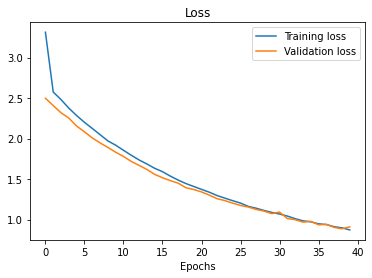

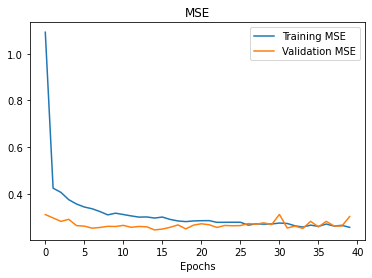

In [52]:
plot_loss_curves(model_10_history)

### Model_11 (Double the number of units in the hidden layers of Model_5)

In [55]:
model_11 = tf.keras.Sequential([
    layers.Dense(166, input_shape = X_train_minmax_tensor[0].shape, name = "input_layer"),
    layers.Dense(200, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(200, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(1, name = "output_layer")
])

model_11.compile(loss = tf.keras.losses.mse,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ["mse"])

model_11_history  = model_11.fit(x = X_train_minmax_tensor, 
                               y = y_train_tensor, 
                               epochs = 40,
                               validation_data = (X_val_minmax_tensor, y_val_tensor),
                               callbacks = [create_tensorboard_callback(dir_name = "nn-predictions",
                                                   experiment_name = "Model_11")])

Saving TensorBoard log files to: nn-predictions/Model_11/20221127-132441
Epoch 1/40
51/51 [==============================] - 1s 8ms/step - loss: 5.2448 - mse: 1.5124 - val_loss: 3.9875 - val_mse: 0.3401
Epoch 2/40
51/51 [==============================] - 0s 5ms/step - loss: 3.9306 - mse: 0.3714 - val_loss: 3.7638 - val_mse: 0.2989
Epoch 3/40
51/51 [==============================] - 0s 5ms/step - loss: 3.7204 - mse: 0.3421 - val_loss: 3.5647 - val_mse: 0.2786
Epoch 4/40
51/51 [==============================] - 0s 5ms/step - loss: 3.5272 - mse: 0.3253 - val_loss: 3.3871 - val_mse: 0.2743
Epoch 5/40
51/51 [==============================] - 0s 4ms/step - loss: 3.3424 - mse: 0.3097 - val_loss: 3.2082 - val_mse: 0.2604
Epoch 6/40
51/51 [==============================] - 0s 5ms/step - loss: 3.1706 - mse: 0.2989 - val_loss: 3.0438 - val_mse: 0.2521
Epoch 7/40
51/51 [==============================] - 0s 5ms/step - loss: 3.0100 - mse: 0.2902 - val_loss: 2.8924 - val_mse: 0.2480
Epoch 8/40
51/51 

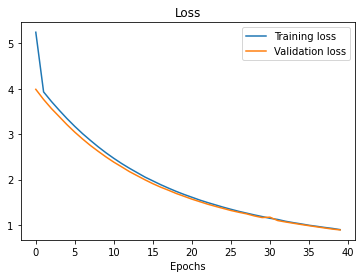

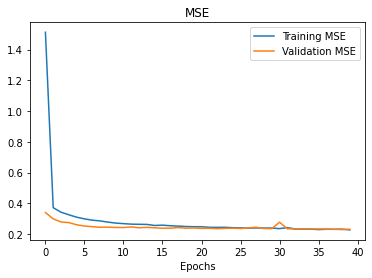

In [57]:
plot_loss_curves(model_11_history)

### Model_12 (Quadruple the number of units in the hidden layers of Model_5)

In [58]:
model_12 = tf.keras.Sequential([
    layers.Dense(166, input_shape = X_train_minmax_tensor[0].shape, name = "input_layer"),
    layers.Dense(400, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(400, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(1, name = "output_layer")
])

model_12.compile(loss = tf.keras.losses.mse,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ["mse"])

model_12_history  = model_12.fit(x = X_train_minmax_tensor, 
                               y = y_train_tensor, 
                               epochs = 40,
                               validation_data = (X_val_minmax_tensor, y_val_tensor),
                               callbacks = [create_tensorboard_callback(dir_name = "nn-predictions",
                                                   experiment_name = "Model_12")])

Saving TensorBoard log files to: nn-predictions/Model_12/20221127-132607
Epoch 1/40
51/51 [==============================] - 1s 11ms/step - loss: 7.0737 - mse: 0.9203 - val_loss: 6.2111 - val_mse: 0.2937
Epoch 2/40
51/51 [==============================] - 0s 9ms/step - loss: 6.0246 - mse: 0.3326 - val_loss: 5.7317 - val_mse: 0.2796
Epoch 3/40
51/51 [==============================] - 0s 9ms/step - loss: 5.5508 - mse: 0.3132 - val_loss: 5.2696 - val_mse: 0.2569
Epoch 4/40
51/51 [==============================] - 0s 8ms/step - loss: 5.1138 - mse: 0.3005 - val_loss: 4.8729 - val_mse: 0.2677
Epoch 5/40
51/51 [==============================] - 0s 8ms/step - loss: 4.7086 - mse: 0.2854 - val_loss: 4.4862 - val_mse: 0.2532
Epoch 6/40
51/51 [==============================] - 0s 8ms/step - loss: 4.3450 - mse: 0.2776 - val_loss: 4.1347 - val_mse: 0.2394
Epoch 7/40
51/51 [==============================] - 0s 9ms/step - loss: 4.0135 - mse: 0.2688 - val_loss: 3.8252 - val_mse: 0.2368
Epoch 8/40
51/51

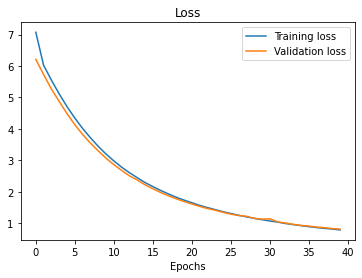

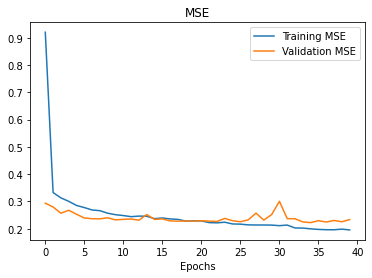

In [59]:
plot_loss_curves(model_12_history)

### Model_13 (Add one hidden layer to Model_11)

In [61]:
model_13 = tf.keras.Sequential([
    layers.Dense(166, input_shape = X_train_minmax_tensor[0].shape, name = "input_layer"),
    layers.Dense(200, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(200, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(200, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(1, name = "output_layer")
])

model_13.compile(loss = tf.keras.losses.mse,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ["mse"])

model_13_history  = model_13.fit(x = X_train_minmax_tensor, 
                               y = y_train_tensor, 
                               epochs = 40,
                               validation_data = (X_val_minmax_tensor, y_val_tensor),
                               callbacks = [create_tensorboard_callback(dir_name = "nn-predictions",
                                                   experiment_name = "Model_13")])

Saving TensorBoard log files to: nn-predictions/Model_13/20221127-132858
Epoch 1/40
51/51 [==============================] - 1s 9ms/step - loss: 6.7916 - mse: 1.1147 - val_loss: 5.8131 - val_mse: 0.3064
Epoch 2/40
51/51 [==============================] - 0s 5ms/step - loss: 5.6947 - mse: 0.3563 - val_loss: 5.4497 - val_mse: 0.2914
Epoch 3/40
51/51 [==============================] - 0s 5ms/step - loss: 5.3257 - mse: 0.3312 - val_loss: 5.0872 - val_mse: 0.2661
Epoch 4/40
51/51 [==============================] - 0s 6ms/step - loss: 4.9813 - mse: 0.3165 - val_loss: 4.7716 - val_mse: 0.2716
Epoch 5/40
51/51 [==============================] - 0s 6ms/step - loss: 4.6536 - mse: 0.3001 - val_loss: 4.4548 - val_mse: 0.2557
Epoch 6/40
51/51 [==============================] - 0s 6ms/step - loss: 4.3526 - mse: 0.2905 - val_loss: 4.1617 - val_mse: 0.2433
Epoch 7/40
51/51 [==============================] - 0s 5ms/step - loss: 4.0730 - mse: 0.2824 - val_loss: 3.8967 - val_mse: 0.2399
Epoch 8/40
51/51 

## Comparison of experiment results using TensorBoard

In [ ]:
# Upload TensorBoard dev records - Results can be viewed in 
# https://tensorboard.dev/experiment/diofNSNyQeCL71pAe3bG2Q/#scalars&runSelectionState=eyJNb2RlbF8wLzIwMjIxMTI3LTEyMjgwMS90cmFpbiI6ZmFsc2UsIk1vZGVsXzAvMjAyMjExMjctMTIyODAxL3ZhbGlkYXRpb24iOmZhbHNlLCJNb2RlbF8xLzIwMjIxMTI3LTEyMjgyMy90cmFpbiI6ZmFsc2UsIk1vZGVsXzEvMjAyMjExMjctMTIyODIzL3ZhbGlkYXRpb24iOmZhbHNlLCJNb2RlbF8xMC8yMDIyMTEyNy0xMzE3MDQvdHJhaW4iOmZhbHNlLCJNb2RlbF8xMC8yMDIyMTEyNy0xMzE3MDQvdmFsaWRhdGlvbiI6ZmFsc2UsIk1vZGVsXzExLzIwMjIxMTI3LTEzMjQ0MS90cmFpbiI6ZmFsc2UsIk1vZGVsXzExLzIwMjIxMTI3LTEzMjQ0MS92YWxpZGF0aW9uIjp0cnVlLCJNb2RlbF8xMi8yMDIyMTEyNy0xMzI2MDcvdHJhaW4iOmZhbHNlLCJNb2RlbF8xMi8yMDIyMTEyNy0xMzI2MDcvdmFsaWRhdGlvbiI6dHJ1ZSwiTW9kZWxfMTMvMjAyMjExMjctMTMyODU4L3RyYWluIjpmYWxzZSwiTW9kZWxfMTMvMjAyMjExMjctMTMyODU4L3ZhbGlkYXRpb24iOnRydWUsIk1vZGVsXzIvMjAyMjExMjctMTIyODQ1L3RyYWluIjpmYWxzZSwiTW9kZWxfMi8yMDIyMTEyNy0xMjI4NDUvdmFsaWRhdGlvbiI6ZmFsc2UsIk1vZGVsXzMvMjAyMjExMjctMTIyOTI2L3RyYWluIjpmYWxzZSwiTW9kZWxfMy8yMDIyMTEyNy0xMjI5MjYvdmFsaWRhdGlvbiI6ZmFsc2UsIk1vZGVsXzQvMjAyMjExMjctMTIyOTQ4L3RyYWluIjpmYWxzZSwiTW9kZWxfNC8yMDIyMTEyNy0xMjI5NDgvdmFsaWRhdGlvbiI6ZmFsc2UsIk1vZGVsXzUvMjAyMjExMjctMTI1MjUxL3RyYWluIjpmYWxzZSwiTW9kZWxfNS8yMDIyMTEyNy0xMjUyNTEvdmFsaWRhdGlvbiI6ZmFsc2UsIk1vZGVsXzYvMjAyMjExMjctMTI1NDI5L3RyYWluIjpmYWxzZSwiTW9kZWxfNi8yMDIyMTEyNy0xMjU0MjkvdmFsaWRhdGlvbiI6ZmFsc2UsIk1vZGVsXzcvMjAyMjExMjctMTI1NjI4L3RyYWluIjpmYWxzZSwiTW9kZWxfNy8yMDIyMTEyNy0xMjU2MjgvdmFsaWRhdGlvbiI6ZmFsc2UsIk1vZGVsXzgvMjAyMjExMjctMTI1ODU4L3RyYWluIjpmYWxzZSwiTW9kZWxfOC8yMDIyMTEyNy0xMjU4NTgvdmFsaWRhdGlvbiI6ZmFsc2UsIk1vZGVsXzkvMjAyMjExMjctMTMxNDU2L3RyYWluIjpmYWxzZSwiTW9kZWxfOS8yMDIyMTEyNy0xMzE0NTYvdmFsaWRhdGlvbiI6ZmFsc2V9&_smoothingWeight=0.5
!tensorboard dev upload --logdir ./nn-predictions/ \
--name "NN regressors for length of hospital stay" \
--description "Improvement of the NN model" \
--one_shot

## Final_model

Based on TensorBoard, Model_12 is the best model

In [66]:
model_12.evaluate(X_test_minmax_tensor, y_test_tensor)

7/7 [==============================] - 0s 4ms/step - loss: 0.8574 - mse: 0.2768


[0.8573504686355591, 0.2768371105194092]